# Classification de locuteur

#### Objectif : créer une chaine de traitement des données textuelles sur la classification de locuteur

#### Jeu de données : citations Chirac Mitterand

* Analyses obligatoires
    * Comparer les performances avec différents pré-traitements
        * e.g Taille de vocabulaire, unigram/bigram, Stemming, ...
    * Implémenter un post-traitement sur les données Chirac/Mitterrand
    * Appliquer les traitements optimaux sur les données de test et sauver les résultats dans un fichier txt

* Compléments optionnels
    * Analyser les performances avec Word2Vec, en utilisant des stratégies d'agrégation naïves

## Import des librairies

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import codecs
import re
import seaborn as sns

In [142]:
path = "data/AFDpresidentutf8/corpus.tache1.learn.utf8"

## Chargement des données Mitterand / Chirac

In [143]:
# Chargement des données:
def load_pres(fname):
    pattern1 = re.compile(r"<[0-9]*:[0-9]*:(.)>.*")
    pattern2 = re.compile(r"<[0-9]*:[0-9]*:.>(.*)")

    with codecs.open(fname, 'r', 'utf-8') as s:
        lines = s.readlines()

    alltxts = [pattern2.sub(r"\1", txt) for txt in lines if len(txt) >= 5]
    alllabs = [-1 if pattern1.sub(r"\1", txt).count('M') > 0 else 1 for txt in lines if len(txt) >= 5]

    return alltxts, alllabs

In [144]:
alltxts,alllabs = load_pres(path)

### Verification de l'équilibre du plan d'expérience

In [145]:
C, M = np.unique(alllabs, return_counts=True)[1]
print(f"Il y a {M/(C+M) * 100} % de citations attribuées à Mitterand et {C/(C+M) * 100} % de citations attribuées à Chirac ")

Il y a 86.89669587027329 % de citations attribuées à Mitterand et 13.103304129726718 % de citations attribuées à Chirac 


On constate que le plan d'expérience n'est pas équilibré. Il va falloir échantilloner notre dataset pour se ramener à une situation à l'équilibre (50% des exemples associés à chaque locuteur).

### Over-sampling dans la classe majoritaire 'Mitterand'

Il y a plusieurs solutions pour gérer les problèmes de déséquilibre de classes.

L'API scikit propose dans la plupart de ses modèles de classifieurs un paramètre `class_weight` qui permet de donner plus de poids aux classes minoritaires. 

La librairie imbalanced-learn propose des méthodes plus avancées pour gérer les problèmes de déséquilibre de classes. En particulier la méthode SMOTE (Synthetic Minority Over-sampling Technique) qui permet de générer des exemples synthétiques de la classe minoritaire (cf [documentation](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn)).

En entrainant le modèle sur les données telles quelles, nous avons obtenue des performances élevées, de l'ordre de 0.93 en accuracy et 0.97 en AUC. Ces metrics diminuent lorsque l'on applique un SMOTE sur les données. **On pourrait penser que c'est une mauvaise idée d'appliquer les algos de ré-échantillonage. Mais en réalité, on cherche à maximiser la performance sur les données de test.** Et on espère ainsi constater que les performances sur les données de test sont meilleures lorsque l'on applique un SMOTE !!!

In [146]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

ros = RandomOverSampler(sampling_strategy='auto')
alltxts_res, alllabs_res = ros.fit_resample(np.array(alltxts).reshape(-1, 1), alllabs)

# ou

# smote = SMOTE(sampling_strategy='auto')
# alltxts_res, alllabs_res = smote.fit_resample(np.array(alltxts).reshape(-1, 1), alllabs)

In [147]:
C, M = np.unique(alllabs_res, return_counts=True)[1]
print(f"Il y a {M/(C+M) * 100} % de citations attribuées à Mitterand et {C/(C+M) * 100} % de citations attribuées à Chirac ")

Il y a 50.0 % de citations attribuées à Mitterand et 50.0 % de citations attribuées à Chirac 


L'over sampling a permis le réequilibrage des classes.

In [148]:
# On réassigne les variables pour plus de clarté dans le code
alltxts, alllabs = alltxts_res, alllabs_res

# Analyse des mots fréquents

In [149]:
import nltk
import string

from nltk.util import ngrams
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords

# Nécessaire pour la première exécution
nltk.download("punkt")
nltk.download("stopwords") 

# Retire la ponctuation et tokenize
translator = str.maketrans("", "", string.punctuation)
tokens = word_tokenize(" ".join(map(str, alltxts)).translate(translator))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ambroisebertin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ambroisebertin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [150]:
# Filtre les stopwords
stop_words = set(stopwords.words("english"))
tokens = [token for token in tokens if token not in stop_words]

freq_dist = FreqDist(tokens)
vocab_size = len(freq_dist)
print(f"Taille du vocabulaire : {vocab_size}")

Taille du vocabulaire : 46170


In [151]:
# Calcule les 100 bigrammes et trigrams les plus fréquents
bigram_freq = FreqDist(ngrams(tokens, 2))
trigram_freq = FreqDist(ngrams(tokens, 3))

top_100_bigrams = bigram_freq.most_common(100)
top_100_trigrams = trigram_freq.most_common(100)

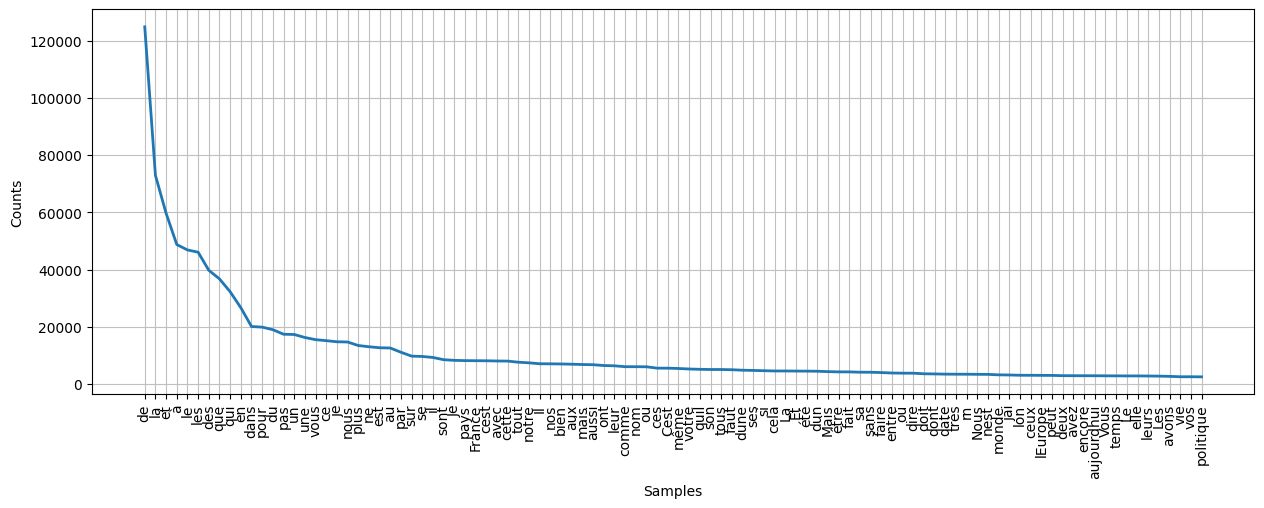

<Figure size 640x480 with 0 Axes>

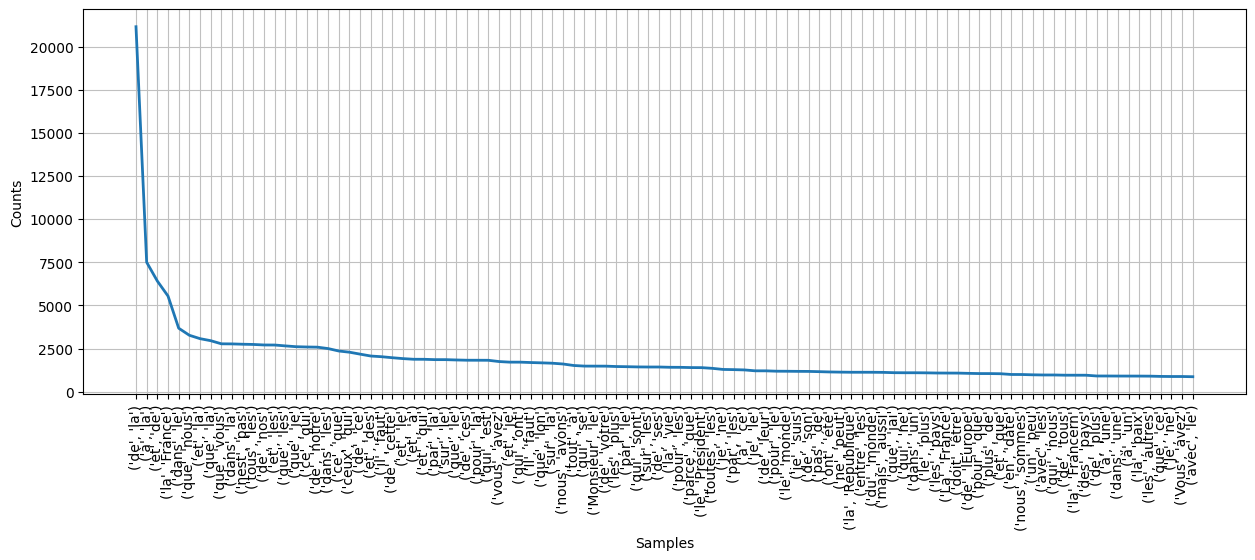

<Figure size 640x480 with 0 Axes>

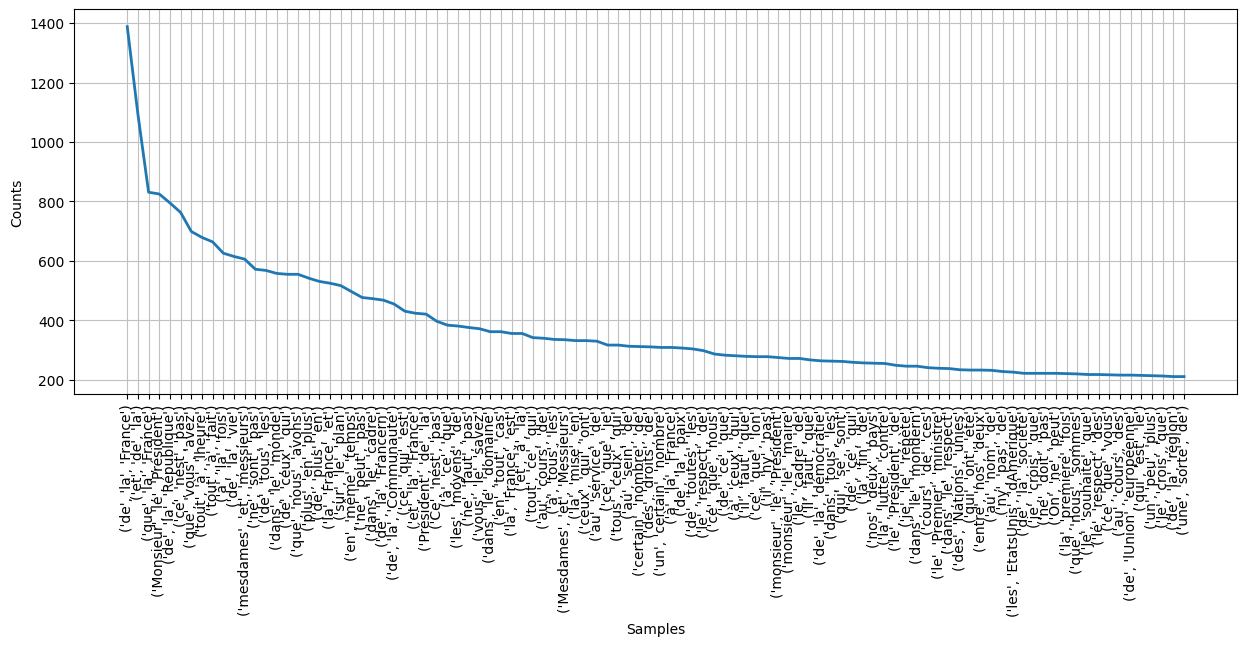

<Figure size 640x480 with 0 Axes>

In [152]:
plt.figure(figsize=(15, 5))
freq_dist.plot(100)
plt.savefig('figures/freq_dist.png')
plt.show()

plt.figure(figsize=(15, 5))
bigram_freq.plot(100)
plt.savefig('figures/bigram_freq.png')
plt.show()

plt.figure(figsize=(15, 5))
trigram_freq.plot(100)
plt.savefig('figures/trigram_freq.png')
plt.show()

# Identification préalable du meilleur modèle parmi différents modèles

A ce stade de l'analyse, on n'effectue pas encore de prétraitement sur les données. On va juste faire tourner différents modèles afin de trouver le modèle optimal à améliorer ensuite.

### Préparation du dataset pour l'apprentissage

On sépare le jeu de donneés en ensembles d'apprentissage et de test.

In [153]:
from sklearn.model_selection import train_test_split

# Diviser le dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(alltxts, alllabs, test_size=0.2, random_state=42)

print("Taille de l'ensemble d'entraînement :", len(train_texts))
print("Taille de l'ensemble de test :", len(test_texts))

Taille de l'ensemble d'entraînement : 79824
Taille de l'ensemble de test : 19956


In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# traitement nécessaire pour lire les données
train_texts_flat = [text for sublist in train_texts for text in sublist]
test_texts_flat = [text for sublist in test_texts for text in sublist]

# Convertir les données en vecteurs
train_vectors = vectorizer.fit_transform(train_texts_flat)
test_vectors = vectorizer.transform(test_texts_flat)

### Définition des différents modèles

On teste différents modèles : Naive Bayes, Logistic Regression, XG Boost et un SVM.

In [155]:
from sklearn.naive_bayes import MultinomialNB

# Créer le classifieur
clf_NB = MultinomialNB()

# Entraîner le classifieur
clf_NB.fit(train_vectors, train_labels)

# Prédire les labels sur l'ensemble de test
pred = clf_NB.predict(test_vectors)

In [156]:
from sklearn.linear_model import LogisticRegression

# Créer le classifieur
clf_LR = LogisticRegression()

# Entraîner le classifieur
clf_LR.fit(train_vectors, train_labels)

# Prédire les labels sur l'ensemble de test
pred = clf_LR.predict(test_vectors)

/Users/ambroisebertin/miniconda3/envs/general/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [157]:
from xgboost import XGBClassifier

# Créer le classifieur
clf_XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Convertir les labels en Series
train_labels_series = pd.Series(train_labels)

# Mapper les labels de -1 et 1 à 0 et 1
train_labels_mapped = train_labels_series.map({-1: 0, 1: 1})

# Entraîner le classifieur avec les labels mappés
clf_XGB.fit(train_vectors, train_labels_mapped)

# Prédire les labels des données de test
pred = clf_XGB.predict(test_vectors)

In [158]:
from sklearn.svm import LinearSVC

# Créer le classifieur
clf_SVM = LinearSVC(C=1.0)

# Entraîner le classifieur
clf_SVM.fit(train_vectors, train_labels)

# Prédire les labels sur l'ensemble de test
pred = clf_SVM.predict(test_vectors)

/Users/ambroisebertin/miniconda3/envs/general/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


## Evaluation des modèles sans prétraitement

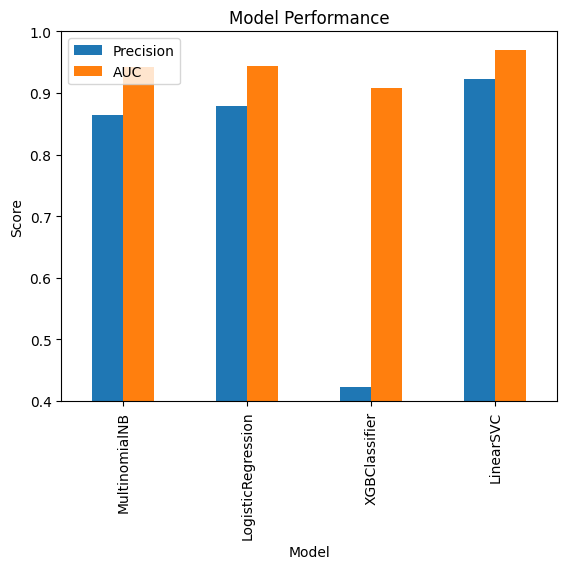

                Model  Precision       AUC
0       MultinomialNB   0.863750  0.942690
1  LogisticRegression   0.878332  0.943358
2       XGBClassifier   0.423482  0.907780
3           LinearSVC   0.922279  0.969889 

Le modèle avec la meilleure précision est LinearSVC
Le modèle avec le meilleur AUC est LinearSVC


In [159]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# on va évaluer chaque modèle avec les métriques "précision" et "AUC"
modele = [clf_NB, clf_LR, clf_XGB, clf_SVM]

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Precision', 'AUC'])

for model in modele:
    model_name = type(model).__name__
    
    # Calculer la précision
    pred = model.predict(test_vectors)
    precision = accuracy_score(test_labels, pred)

    # Cas particulier pour le modele SVM qui ne possède pas de méthode predict_proba
    if hasattr(model, 'predict_proba'):
        # Calculer l'auc
        pred_proba = model.predict_proba(test_vectors)[:, 1]
    elif hasattr(model, 'decision_function'):  # utiliser decision_function pour le modele SVM qui n'a pas de méthode predict_proba
        pred_proba = model.decision_function(test_vectors)
    else:
        print(f"Le modèle {model_name} n'a pas de méthode pour calculer la probabilité", "\n")
        continue

    fpr, tpr, _ = roc_curve(test_labels, pred_proba)
    roc_auc = auc(fpr, tpr)

    # Ajouter les résultats dans un DataFrame qu'on va ensuite afficher pour synthétiser les résultats
    results.loc[len(results)] = [model_name, precision, roc_auc]

# Afficher les résultats sous forme de graphique
results.plot(kind='bar', x='Model', y=['Precision', 'AUC'])
plt.title('Model Performance')
plt.ylabel('Score')
plt.ylim([0.4, 1])
plt.legend(['Precision', 'AUC'])
plt.show()

# Afficher le tableau de synthèse des résultats
print(results,"\n")

max_precision = results['Precision'].max()
max_auc = results['AUC'].max()

# Indiquer quels sont les modèles qui ont la meilleure précision et le meilleur AUC
best_precision_models = results[results['Precision'] == max_precision]['Model'].values
best_auc_models = results[results['AUC'] == max_auc]['Model'].values

print(f"Le modèle avec la meilleure précision est {', '.join(best_precision_models)}")
print(f"Le modèle avec le meilleur AUC est {', '.join(best_auc_models)}")


On observe à ce stade que le modèle avec les meilleures performances (selon les métriques évaluées) est le SVM. On va donc poursuivre en cherchant à améliorer ce modèle.

# Tentatives d'amélioration du meilleur modèle en utilisant différents prétraitements

On va mettre en place différents prétraitements pour voir si cela peut permettre d'augmenter les performances du modèle.

In [160]:
# import outils de preprocessing
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("punkt")
nltk.download("stopwords")

from functools import partial
from unidecode import unidecode


def preprocess(text, remove_punctuation=True, use_stemming=True, remove_stopwords=True):
    # En anglais, à priori les accents et autres caractères spéciaux ne sont très utiles
    # dans ce contexte, on peut donc normaliser le texte en retirant ces caractères
    
    text = text.lower()
    text = unidecode(text)

    tokens = nltk.word_tokenize(text)

    if remove_punctuation:
        tokens = [token for token in tokens if token not in string.punctuation]

    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens = [token for token in tokens if token not in stop_words]

    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ambroisebertin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ambroisebertin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def train_and_predict_svm(train_vectors, train_labels, test_vectors):
    from sklearn.svm import LinearSVC

    # Create the classifier
    clf_SVM = LinearSVC(C=1.0)

    # Train the classifier
    clf_SVM.fit(train_vectors, train_labels)

    # Predict the labels on the test set
    pred = clf_SVM.predict(test_vectors)

    return pred

On va ensuite tester les différentes combinaisons de ces trois pré-traitements pour entraîner le LinearSVC. On espère obtenir un modèle plus performant que sans les prétraitements.

In [ ]:
from sklearn.model_selection import train_test_split

# Diviser le dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(alltxts, alllabs, test_size=0.2, random_state=42)

print("Taille de l'ensemble d'entraînement :", len(train_texts))
print("Taille de l'ensemble de test :", len(test_texts))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(preprocessor)

# traitement nécessaire pour lire les données
train_texts_flat = [text for sublist in train_texts for text in sublist]
test_texts_flat = [text for sublist in test_texts for text in sublist]

# Convertir les données en vecteurs
train_vectors = vectorizer.fit_transform(train_texts_flat)
test_vectors = vectorizer.transform(test_texts_flat)

In [ ]:
preprocess(train_vector, remove_punctuation=True)




# Optimisation des hyperparamètres du modèle le plus performant

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100]}

# Initialize GridSearchCV
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5)

# Fit GridSearchCV to the training data
grid_search.fit(train_vectors, train_labels)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

# Train and predict with the best parameters
clf_SVM = LinearSVC(C=best_params['C'])
clf_SVM.fit(train_vectors, train_labels)
pred = clf_SVM.predict(test_vectors)

On obtient que le paramètre C optimal est égal à 10. On obtient donc :

In [ ]:
from sklearn.metrics import roc_auc_score

# display the accuracy and AUC scores of the best model
accuracy = accuracy_score(test_labels, pred)
auc = roc_auc_score(test_labels, pred)

print(f"Accuracy: {accuracy}, AUC: {auc}")